# Interdependent Security Games

_ECE 302 Project_<br>
_Alan A. Chung Ma_<br>
_April 24, 2023_

This project follows much of the work that is laid out in [this paper](https://engineering.purdue.edu/~sundara2/papers/HotaSundaramGameSec2015.pdf).

In this project, we will first look at a basic game to introduce the reader to the notion of Nash Equilibria and follow it by exploring the _interdependent security_ games that are in the the aforementioned paper ([Hota & Sundaram, 2015](https://engineering.purdue.edu/~sundara2/papers/HotaSundaramGameSec2015.pdf)). We will then look at how they are affected by a behavioral probability weighting. My goal for this project was to better understand how probability weighting can affect the outcome of a game and offer a simple and interactive introduction to the topics introduced.

A thorough background of the problem space is given succintly in the paper. Therefore, I will only briefly touch on the problem space and offer a brief introduction to some of the methods utilized.

In [1]:
%matplotlib notebook
from IPython.display import display
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

## 1. Background and Goals

Interdependent security games are a class of games where the players decide on their own personal investments in security, and the security risk faced by each player depends on the collective investment of the other players. I am personally interested on how this model could be used to analyze computer security investments. In the real world, players would act on perceived probabilities rather than on actual probabilities, therefore, we will compare the results will between the games with and without probability weighting.

The following sub-sections outline some of the fundamental concepts that will be used throughout the notebook.

### 1.1 Probabilistic Methods

In this project, we will be dealing with a Bernoulli random variable $X \sim Ber(p)$ which denotes whether or not a successful attack on a system occured, where $p$ is the value of the probabilistic mass function (PDF) of $X$ at $1$ such that $p_X(1) = p$. The expected value of $X$ is given by $E[X] = p$.

### 1.2 Game Theory

Every player in a game has a utility function $\pi_i$ which denotes their "profit." Every player will look to maximize their corresponding utility function disregarding that of the other players. Some of the games below have a pure strategy Nash Equilibrie (PNE), which is when every player plays a strategy $s_i$ such that it maximizes their own utility when other players play $s_{-i}$ (this is the convention which denotes the strategies of all players other than player $i$). $s = (s_1, \dots, s_n)$ denotes the strategy profile of all $n$ players.

// TODO: social optimum?

## 2. Security Games

Let $n$ be the total number of players, and let $s_i \in [0,1]$ be the investment in security made by player $i$. Each player $i$ has a cost-per-unit of security investment of $b_i \in \mathbb{R}^+$ and a loss of $L_i \in \mathbb{R}^+_*$ when a successful attack occurs. We also have $X_i \sim Ber(f_i(s))$, where $f_i(s_i, s_{-i}) \in [0,1]$ is the probability of a successful attack occuring to player $i$'s system; notice that $f_i(s)$ is a function of the strategy profile of all players. We can now define the utility of each player as
$$
\pi_i(s_i, s_{-i}) = -L_iX_i - b_is_i
$$
and then define the expected utility of each player $i$ as
$$
E[\pi_i(s_i, s_{-i})] = -L_iE[X_i] - b_is_i \\
\qquad\qquad\qquad= -L_if_i(s_i, s_{-i}) - b_is_i
$$

### 2.1 Example Game

Before I introduce the models of interdependent security games, let's look at a model where the probability of getting attacked only depends on the each player's own investment where $f_i(s_i, s_{-i}) = 1 - s_i$. We can now look at the expected utility and find $s_i^*$ that maximizes the utility:

$$
max_{s_i \in [0,1]} E[\pi_i] = max_{s_i \in [0,1]} -L_i(1 - s_i) - b_is_i \\
\qquad\qquad\quad = max_{s_i \in [0,1]} s_i(L_i - b_i)-L_i
$$

There are now three scenarios, each with a different best response:
- $L_i > b_i$: $s_i^* = 1$
- $L_i < b_i$: $s_i^* = 0$
- $L_i = b_i$: player is indifferent, no best response

Below, I have a dynamic graph which showcases the above, feel free to move around the variables to view how the PNE changes as the parameters change.

<IPython.core.display.Javascript object>


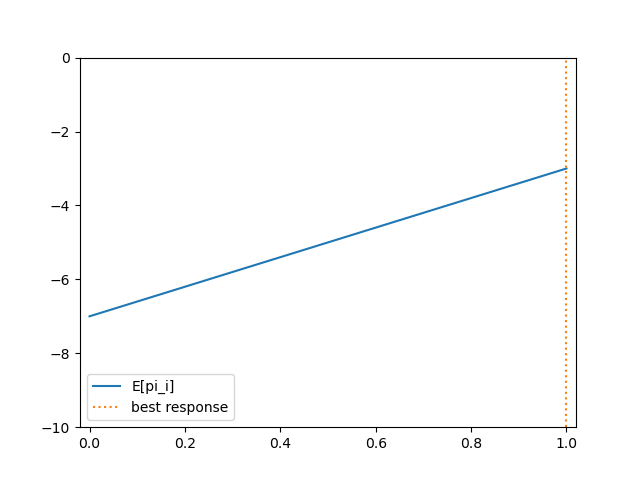

interactive(children=(FloatSlider(value=7.0, description='L', max=10.0, min=0.01, step=0.01), FloatSlider(valu…

In [2]:
s_i = np.linspace(0, 1,1000)
y = np.linspace(-10, 0, 10)

E_pi = lambda s_i, L_i, b_i: s_i * (L_i - b_i) - L_i

L_widget = widgets.FloatSlider(
    value = 7,
    min = 0.01,
    max = 10,
    step = 0.01,
)
b_widget = widgets.FloatSlider(
    value = 3,
    min = 0,
    max = 10,
    step = 0.01,
)

fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.axis([-0.02, 1.02, -10, 0])
line, = ax1.plot(s_i, E_pi(s_i, L_i = 7, b_i = 3), label="E[pi_i]")
best, = ax1.plot(np.ones(10), y, ':', label="best response")
ax1.legend(loc="lower left")

@interact(L = L_widget, b = b_widget)
def update(L = 7, b = 3):
    line.set_ydata(E_pi(s_i, L, b))
    if L > b:
        best.set_ydata(y)
        best.set_xdata(np.ones(10))
    elif L < b:
        best.set_ydata(y)
        best.set_xdata(np.zeros(10))
    else:
        best.set_xdata(s_i)
        best.set_ydata(E_pi(s_i, L, b))
    fig1.canvas.draw_idle()

### 2.2 Interdependent Security Games

The paper introduces three models of interdependent security games. They are as follows:
- _Total Effort_: $\quad f_i(s_i, s_{-i}) = 1 - \frac{1}{n}\sum_{i=1}^n s_i$
- _Weakest Link_: $\quad f_i(s_i, s_{-i}) = 1 - \min_{k = 1}^n s_k$
- _Best Shot_: $\quad f_i(s_i, s_{-i}) = 1 - \max_{k = 1}^n s_k$

Each interdependent model describes a unique scenario where the resilience of player $i$'s computer system from successful attacks depends on the security investment of other players. _Total Effort_ describes a scenario where the probability relies on the average investment of all players; _Weakest Link_ describes a scenario where the probability solely relies on the player that invested the least and _Best Shot_ relies on the player that invested the most. The paper outlines the PNE for each of the models above when all $n$ players share the homogeneous cost parameters $b$ and $L$, which will be outlined below. Proof omitted:
- _Total Effort_: There is a unique symmetric PNE except for the special case where $\frac{nb}{L} = 1$. If $\frac{nb}{L} < 1$ then $s_i^* = 1$. Otherwise if $\frac{nb}{L} > 1$, $s_i^* = 0$.
- _Weakest Link_: If $\frac{b}{L} > 1$, then $s_i^* = 0$ for every player. Otherwise, any investment $s_i^* \in [0,1]$ where every player invests the same amount.
- _Best Shot_: If $\frac{b}{L} > 1$, then $s_i^* = 0$ for every player. Otherwise, at most one player makes an investment of $1$ while all other players make no investment.

## 3. Probability Weighting

One of the main focuses of the paper was the effects of probability weighting of objective probabilities on players in interdependent security games. Probability weighting has been extensively studied in behavioral economics and psychology, and three fundamental characteristics to probability weighting exist:
1. _Possibility effect_: overweighting of probabilities very close to 0.
2. _Certainty effect_: underweighting of probabilities very close to 1.
3. _Diminishing sensitivity_ from the end points 0 and 1.

The probability weighting function the paper used is given by
$$
w(x) = \exp(-(-\ln x)^\alpha), \quad x \in [0,1], \alpha \in (0,1]
$$
You can see how parameter $\alpha$ changes the shape of $w(x)$, as well as $w'(x)$, the first derivative of $w$. The horizontal axis denotes the actual probability and the vertical axis denotes the perceived probability for the figure on the left, and the first derivative of $w(x)$ on the figure to the right.

Note the the minimum value of $w'(x)$ over $x\in [0,1]$ is $\alpha$.

<IPython.core.display.Javascript object>


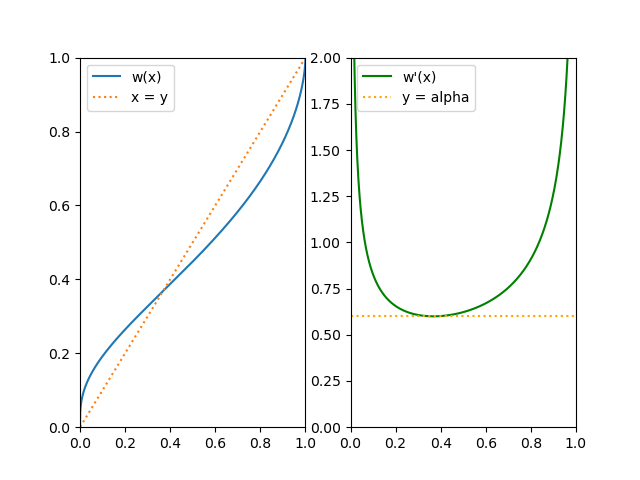

interactive(children=(FloatSlider(value=0.6, description='alpha', max=1.0, min=0.01, step=0.01), Output()), _d…

In [3]:
x = np.linspace(0.001, 1, 1000 - 1)
w = lambda x, alpha: np.exp(-1 * (-1 * np.log(x)) ** alpha)

alpha_widget = widgets.FloatSlider(
    value = 0.6,
    min = 0.01,
    max = 1,
    step = 0.01,
)

fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 2, 1)
ax2.axis([0, 1, 0, 1])
w_line, = ax2.plot(np.insert(x, 0, 0), np.insert(w(x, alpha=0.6), 0, 0), label="w(x)")
ax2.plot(x, x, ":", label="x = y")
ax2.legend(loc="upper left")
    
xs = np.linspace(0.001, 0.999, 1000)
w_prime = lambda x, alpha: -1 * alpha * w(x, alpha) * (-1 * np.log(x))**alpha / (x * np.log(x))

ax3 = fig2.add_subplot(1, 2, 2)
ax3.axis([0, 1, 0, 2])
wp_line, = ax3.plot(xs, w_prime(xs, alpha=0.6), label="w'(x)", color="green")
alpha_line, = ax3.plot(xs, np.ones(len(xs)) * 0.6, ":", label="y = alpha", color="orange")
ax3.legend(loc="upper left")

@interact(alpha = alpha_widget)
def update(alpha = 0.6):
    w_line.set_ydata(np.insert(w(x, alpha), 0, 0))
    wp_line.set_ydata(w_prime(xs, alpha))
    alpha_line.set_ydata(np.ones(len(xs)) * alpha)
    fig2.canvas.draw_idle()

## 4. Simple Security Game with Probability Weighting

We can easily incorporate probability weighting into the utility of the player by passing the probability $f(s_i, s_{-i})$ through the function $w(x)$, as can be seen below.
$$
E[\pi_i] = -L_iw(f_i(s_i, s_{-i})) - b_is_i
$$

Applying the utility function above with the simple self-dependent model introduced in 2.1, you obtain a new model
$$
E[\pi_i] = -L_iw(1 - s_i) - b_is_i
$$

As can be seen below, the highest point at varying values of $L_i, b_i$ are the same between actual probability and weighted probability regardless of the value of the parameters. Therefore, the PNE is the same when probability weighting is applied or not.

<IPython.core.display.Javascript object>


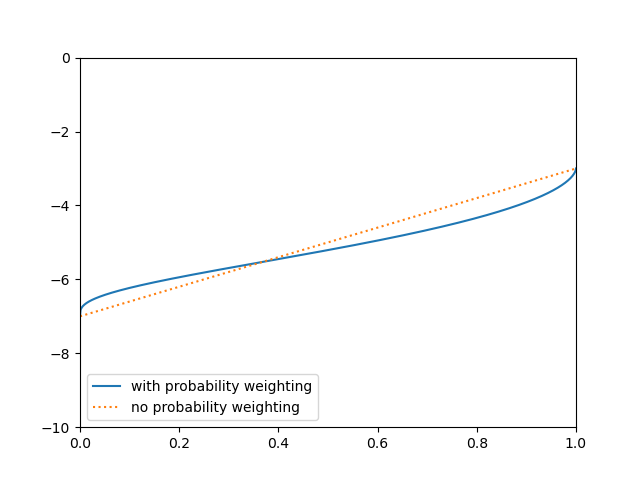

interactive(children=(FloatSlider(value=0.6, description='alpha', max=1.0, min=0.01, step=0.01), FloatSlider(v…

In [4]:
fig3 = plt.figure()
ax4 = fig3.add_subplot()
ax4.axis([0, 1, -10, 0])
simple_weighted, = ax4.plot(s_i, E_pi(np.insert(w(x, alpha=0.6), 0, 0), L_i = 7, b_i = 3), label="with probability weighting")
simple_unweighted, = ax4.plot(s_i, E_pi(s_i, L_i = 7, b_i = 3), ":", label="no probability weighting")
ax4.legend(loc="lower left")

@interact(alpha = alpha_widget, L = L_widget, b = b_widget)
def update(alpha = 0.6, L = 7, b = 3):
    simple_weighted.set_ydata(E_pi(np.insert(w(x, alpha), 0, 0), L, b))
    simple_unweighted.set_ydata(E_pi(s_i, L, b))
    fig3.canvas.draw_idle()

## 5. Interdependent Security Games with Probability Weighting

We will now look at how probability weighting affects the interdependent security games. To make the problem at hand simpler, the games which will be considered will assume that parameters $L_i, b_i$ are the same for all players where $\forall i. L_i = L \land b_i = b$. If interested, the paper does look at _Total Effort_ games under probability weighting with heterogeneous players.

Similar to section 2.2, the paper has solved for us the existence and values of the PNE for the game models. I will mainly be providing a tool to observe the effects of probability weighting to the equilibria and offer some observations. I will also be omitting the proofs for the PNE obtained as I doubt I can explain them better than the way they were presented on the paper.

### 5.1 Total Effort Game with Probability Weighting with Homogeneous Players

In a _Total Effort_ game with probability weighting, the expected utility of player $i$ is given by
$$
E[\pi_i(s_i,s_{-i})] = -Lw\left(1 - \frac{s_i + \bar{s}_{-i}}{n}\right)-bs_i, \quad \text{where } \bar{s}_{-i}=\sum_{j\neq i}s_j
$$

If $\alpha > \frac{nb}{L}$, investing 1 is the only best response for player $i$ irrespective of the strategies of the other players. If $\alpha = 1$, the probability weighting function is linear and the PNE corresponds to that discussed in section 2.2. However, if $\alpha < \frac{nb}{L}$, more work will need to be established. Let's denote the solutions to $w'(x)=\frac{nb}{L}$ as $X_1$ and $X_2$, where $X_1 <\frac{1}{e}$ and $X_2 > \frac{1}{e}$ and only consider games with a sufficiently large $n$ such that $X_2 - X_1 > \frac{1}{n}$. Then,
- any strategy profile with $X_2 = 1 - \frac{s_i + \bar{s}_{-i}}{n}$ is a PNE
- any strategy profile with $X_1 = 1 - \frac{s_i + \bar{s}_{-i}}{n}$ is not a PNE
- there exists a PNE with all players investing 1 if and only if
    - $X_1 \geq \frac{1}{n}$, or
    - $X_1 < \frac{1}{n}$ and $w\left(\frac{1}{n}\right) > \frac{b}{L}$

Below I have created a widget that allows you to view how PNE changes as the parameters $\alpha, n, L, b$ change and compare it to the result of a game without probability weighting. Note: It only looks for symmetric PNE and I take the smallest possible value I could calculate.

In [5]:
n_widget = widgets.IntSlider(
    value=5,
    min=2,
    max=20,
)

def get_unweighted_pne(n, L, b):
    if n * b / L < 1:
        return 1
    elif n * b / L > 1:
        return 0
    return None

def get_weighted_pne(alpha, n, L, b):
    if alpha > n * b / L:
        return 1
    elif alpha == 1:
        return get_unweighted_pne(n, L, b)
    
    x_1 = root_scalar(lambda x: w_prime(x, alpha) - (n * b / L), bracket=[1e-32, alpha]).root
    x_2 = root_scalar(lambda x: w_prime(x, alpha) - (n * b / L), bracket=[alpha, 1 - 1e-16]).root
    if x_2 - x_1 <= 1/n:
        return None
    
    s_a = 1 - x_2
    return 1 - x_2

@interact(alpha=alpha_widget, n=n_widget, L=L_widget, b=b_widget)
def update(alpha=0.6, n=5, L=10, b=1):
    wpne = get_weighted_pne(alpha, n, L, b)
    upne = get_unweighted_pne(n, L, b)
    
    if wpne == None:
        display("PNE with probability weighting: not unique")
    else:
        display(f"PNE with probability weighting: {wpne}")
    if upne == None:
        display("PNE without probability weighting: not unique")
    else:
        display(f"PNE without probability weighting: {upne}")
    
    if wpne != None and upne != None:
        display(f"Difference of PNE calculated w/ w(x): {abs(upne - wpne)}")
    else:
        display("Could not compare PNE")

interactive(children=(FloatSlider(value=0.6, description='alpha', max=1.0, min=0.01, step=0.01), IntSlider(val…

### 5.2 Weakest Link and Best Shot Games

A _Weakest Link_ game with homogeneous players and probability weighting as defined previously. At any PNE, all players have identical investments. If $\frac{b}{L} > w'(z)$ where $w'(z)=\frac{w(z)}{z}$, then there is a a PNE with attack probability greater than or equal to $X_2$. When $\frac{b}{L} < w'(z)$, then there are additional equilibria with attack probabilities less than $\frac{1}{e}$.

As for a _Best Shot_ game with the same parameters as above, the PNE is similar to that without probability weighting. Except that at any PNE, the only player investing, $j$, has a relaxed constraint where their investment needs to satisfy the following
- If $\frac{b}{L} < w'(z)$, $s_j^* = 1$
- Otherwise, $s_j^* = 1 - X_2$ where $w'(X_2)=\frac{b}{L}$

## 6. Conclusion

There may be some minor mistakes throughout my calculations, but I am pretty confident on most of the work throughout the page. It can be seen that probability weighting can change the best response of each player and cause them to invest an "unoptimal" amount.

- _Total Effort_: Players invest a value when they could have gotten away with investing nothing.
- _Weakest Link_: Players would open themselves up unnecessarily to attacks by investing less than 1.
- _Best Shot_: Since the only player investing would invest less than 1, they would open every other player up to attacks.

The findings are very analogous to firms' investment to computer security. In scenarios where they can do little to protect themselves or the probability of a certain attack is minimal, firms usually invest more since they overweight probabilities close to 0 due to the _possibility effect_. In other scenarios where fully securing a computer system is possible or when the type of attack is very oftem successful, firms fail to invest enought to fully secure the system since probabilities close to 1 are underweighted due to the _certainty effect_.

This can also be seen in other problem spaces outside of just security. Therefore, similar patterns can be seen in fields such as chance games.